In [1]:
#Import stuff
import uproot4
import numpy as np
import awkward as ak
from scipy.stats import norm
from scipy.optimize import curve_fit
import os
import copy

import tensorflow.keras as keras
import tensorflow as tf
import tensorflow_model_optimization as tfmot

from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential, load_model

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.model_selection import train_test_split

import optparse
import importlib
import pathlib
from keras import optimizers
from qkeras.quantizers import quantized_bits, quantized_relu
from qkeras.qlayers import QDense, QActivation
from qkeras import QConv1D
from qkeras.utils import load_qmodel

import hist
from hist import Hist

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.pyplot import cm
import mplhep as hep
plt.style.use(hep.style.ROOT)

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

#line thickness
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 5

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=500)])
    except RuntimeError as e:
        print(e)

model_name = '../models/merged_pt_regress_jet_ID.h5'

2023-08-29 17:07:54.641523: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-29 17:07:54.744803: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-29 17:07:54.747945: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-08-29 17:07:54.747956: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [2]:
import random

random.seed(1111)
tf.random.set_seed(1111)
np.random.seed(1111)

def create_train_test_data(dir_path, test_index=400000, train = True):
        
    #Might have to change the version for other ntuple files
    sig = uproot4.open(dir_path+"/test_sig_v12_emseed.root")
    bkg = uproot4.open(dir_path+"/test_bkg_v12_emseed.root")
    qcd = uproot4.open(dir_path+"/test_qcd_v12_emseed.root")
    
    if train:
        sig_input = sig['ntuplePupSingle']['tree']['m_inputs'].array()[:test_index]
        bkg_input = bkg['ntuplePupSingle']['tree']['m_inputs'].array()[:test_index]
        qcd_input = qcd['ntuplePupSingle']['tree']['m_inputs'].array()

        truth_pt_sig = np.asarray(sig['ntuplePupSingle']['tree']['genpt1'].array()[:test_index])
        truth_pt_bkg = np.asarray(bkg['ntuplePupSingle']['tree']['genpt1'].array()[:test_index])
        truth_pt_qcd = np.asarray(qcd['ntuplePupSingle']['tree']['genpt1'].array())

        reco_pt_sig = sig['ntuplePupSingle']['tree']['pt'].array()[:test_index]
        deltaR_sig = sig['ntuplePupSingle']['tree']['gendr1'].array()[:test_index]
        eta_sig = sig['ntuplePupSingle']['tree']['geneta1'].array()[:test_index]
        selection_sig = (reco_pt_sig > 0.) & (abs(deltaR_sig) < 0.4) & (abs(eta_sig) < 2.4)
        y_sig_pT = truth_pt_sig[selection_sig]

        reco_pt_bkg = bkg['ntuplePupSingle']['tree']['pt'].array()[:test_index]
    else:
        sig_input = sig['ntuplePupSingle']['tree']['m_inputs'].array()[test_index:]
        bkg_input = bkg['ntuplePupSingle']['tree']['m_inputs'].array()[test_index:]
        qcd_input = qcd['ntuplePupSingle']['tree']['m_inputs'].array()

        truth_pt_sig = np.asarray(sig['ntuplePupSingle']['tree']['genpt1'].array()[test_index:])
        truth_pt_bkg = np.asarray(bkg['ntuplePupSingle']['tree']['genpt1'].array()[test_index:])
        truth_pt_qcd = np.asarray(qcd['ntuplePupSingle']['tree']['genpt1'].array())
        reco_pt_sig = sig['ntuplePupSingle']['tree']['pt'].array()[test_index:]
        deltaR_sig = sig['ntuplePupSingle']['tree']['gendr1'].array()[test_index:]
        eta_sig = sig['ntuplePupSingle']['tree']['geneta1'].array()[test_index:]
        selection_sig = (reco_pt_sig > 0.) & (abs(deltaR_sig) < 0.4) & (abs(eta_sig) < 2.4)
        y_sig_pT = truth_pt_sig[selection_sig]

        reco_pt_bkg = bkg['ntuplePupSingle']['tree']['pt'].array()[test_index:]
        
    
    selection_bkg = reco_pt_bkg > 11.5
    y_bkg_pT = truth_pt_bkg[selection_bkg]
    reco_pt_qcd = qcd['ntuplePupSingle']['tree']['pt'].array()
    selection_qcd = reco_pt_qcd > 11
    y_qcd_pT = truth_pt_qcd[selection_qcd]
        
    #Inputs: pt, eta, phi, particle id(one hot encoded)
    X_sig = np.nan_to_num(np.asarray(sig_input[selection_sig]))
    y_sig = np.full(X_sig.shape[0], 1.)
    sig_pt = np.asarray(reco_pt_sig[selection_sig])
    
    X_bkg = np.nan_to_num(np.asarray(bkg_input)[selection_bkg])
    y_bkg = np.full(X_bkg.shape[0], 0.)
    bkg_pt = np.asarray(reco_pt_bkg[selection_bkg])
    
    X_qcd = np.nan_to_num(np.asarray(qcd_input)[selection_qcd])
    y_qcd = np.full(X_qcd.shape[0], 0.)
    qcd_pt = np.asarray(reco_pt_qcd[selection_qcd])
    
    background_pt = np.concatenate([bkg_pt, qcd_pt])
    
    print(y_sig, y_bkg, y_qcd)
    
    if train:
        X_bkg = list(X_bkg)
        y_bkg = list(y_bkg)
        y_bkg_pT = list(y_bkg_pT)
        percent = 0.64
        for _ in range(int(percent*len(X_bkg))):
            n = len(X_bkg)
            random_ind = random.randint(0, n - 1)
            del X_bkg[random_ind]
            del y_bkg[random_ind]
            del y_bkg_pT[random_ind]
        X_bkg = np.asarray(X_bkg)
        y_bkg = np.asarray(y_bkg)
        y_bkg_pT = np.asarray(y_bkg_pT)
        
        X_qcd = list(X_qcd)
        y_qcd = list(y_qcd)
        y_qcd_pT = list(y_qcd_pT)
        for _ in range(int(percent*len(X_qcd))):
            n = len(X_qcd)
            random_ind = random.randint(0, n - 1)
            del X_qcd[random_ind]
            del y_qcd[random_ind]
            del y_qcd_pT[random_ind]
        X_qcd = np.asarray(X_qcd)
        y_qcd = np.asarray(y_qcd)
        y_qcd_pT = np.asarray(y_qcd_pT)

    X_train = np.concatenate([X_sig, X_bkg, X_qcd])
    y_train_jetID = np.concatenate([y_sig, y_bkg, y_qcd])
    MinBias_pT_1 = [1 for i in y_bkg_pT]
    qcd_pT_1 = [1 for i in y_qcd_pT]
#     y_train_pT = np.concatenate([y_sig_pT / sig_pt, y_bkg_pT / bkg_pT, y_qcd_pT / qcd_pt])
    y_train_pT = np.concatenate([y_sig_pT / sig_pt, MinBias_pT_1, qcd_pT_1])
    pt_array = np.concatenate([sig_pt, bkg_pt, qcd_pt])
    
    X_train[abs(X_train) > 1e+9] = 0.
    
    assert not np.any(np.isnan(X_train))
    assert not np.any(np.isnan(y_train_jetID))
    assert not np.any(np.isnan(y_train_pT))
    
    return X_train, y_train_jetID, y_train_pT

X_train_jetID, y_train_jetID,y_train_pT_regress = create_train_test_data("../../ntuples/Jan_25_2023", train=True)
X_test_jetID, y_test_jetID, y_test_pT_regress = create_train_test_data("../../ntuples/Jan_25_2023", train=False)
X_train = X_train_jetID
y_train = y_train_pT_regress
X_test = X_test_jetID
y_test = y_test_pT_regress

[1. 1. 1. ... 1. 1. 1.] [0. 0. 0. ... 0. 0. 0.] [0. 0. 0. ... 0. 0. 0.]
[1. 1. 1. ... 1. 1. 1.] [0. 0. 0. ... 0. 0. 0.] [0. 0. 0. ... 0. 0. 0.]


In [3]:
print(len(X_train_jetID))
print(len(y_train_jetID))
print(len(y_train_pT_regress))
print(X_train_jetID)
print(y_train_jetID)
print(y_train_pT_regress)

211633
211633
211633
[[ 8.9500e+01  0.0000e+00  0.0000e+00 ...  0.0000e+00  0.0000e+00
   0.0000e+00]
 [ 2.8750e+01  0.0000e+00  0.0000e+00 ...  0.0000e+00  0.0000e+00
   0.0000e+00]
 [ 5.1000e+01  0.0000e+00  0.0000e+00 ...  0.0000e+00  0.0000e+00
   0.0000e+00]
 ...
 [ 3.9000e+01 -7.8125e-02 -3.1250e-02 ...  0.0000e+00  0.0000e+00
   1.0000e+00]
 [ 1.4000e+01  0.0000e+00 -1.5625e-02 ...  0.0000e+00  0.0000e+00
   1.0000e+00]
 [ 2.4250e+01  1.5625e-02  0.0000e+00 ...  0.0000e+00  0.0000e+00
   0.0000e+00]]
[1. 1. 1. ... 0. 0. 0.]
[0.98325592 1.86459839 0.84331274 ... 1.         1.         1.        ]


## Model

In [4]:
def merged_model():

    inputs = tf.keras.layers.Input(shape=(80,), name='model_input')
    
    main_branch = tf.keras.layers.Dense(25, activation = "ReLU", name='Dense1')(inputs)
    main_branch = tf.keras.layers.Dense(25, activation = "ReLU", name='Dense2')(main_branch)
    main_branch = tf.keras.layers.Dense(15, activation = "ReLU", name='Dense3')(main_branch)
    main_branch = tf.keras.layers.Dense(15, activation = "ReLU", name='Dense4')(main_branch)
    main_branch = tf.keras.layers.Dense(10, activation = "ReLU", name='Dense5')(main_branch)

    jetID_branch = tf.keras.layers.Dense(1, activation='sigmoid', name='jetID_output')(main_branch)

    pT_branch = tf.keras.layers.Dense(1, name='pT_output')(main_branch)

    model = tf.keras.Model(inputs = inputs, outputs = [jetID_branch, pT_branch])
    
    return model

In [5]:
# Coupling Loss Functions

def compile_model(model, gamma):
    opt = optimizers.Adam()
    model.compile(optimizer=opt,
                  loss={'jetID_output': 'binary_crossentropy', 
                        'pT_output': 'mean_squared_error'},
                  loss_weights={'jetID_output': gamma, 
                                'pT_output': 1 - gamma}, 
                  metrics=['accuracy'])
        
    return model

In [6]:
import time
X_train = X_train_jetID

# FIT BATCH OF MODELS

def fit_batch(gamma_values):
    
    history = list()
    trained_models = list()
    
    print('Starting training on batch of models for gamma values ', gamma_values, '\n\n')
    
    for gamma in gamma_values:
        callback = tf.keras.callbacks.EarlyStopping(verbose = 1, patience=5)
        print('Training model for gamma equal to ', gamma)
        #quantize_annotate_layer = tfmo.quantization.keras.quantize_annotate_layer
        model = merged_model()
        # Quantize the entire model.
        #model = tfmot.quantization.keras.quantize_model(model)
        model = compile_model(model, gamma)
        model.summary()
        
        start = time.time()
        model_history = model.fit({'model_input': X_train},
                            {'jetID_output': y_train_jetID, 'pT_output': y_train_pT_regress},
                            epochs=20, batch_size=256, verbose=2, validation_split=0.20, callbacks = [callback])
        print(f'Training time: {time.time() - start}\n')
        history.append(model_history)
        trained_models.append(model)
        
    return history, trained_models

In [7]:
gammas = [0.3, 0.6, 0.65, 0.7]
training_history, trained_models = fit_batch(gammas)

Starting training on batch of models for gamma values  [0.3, 0.6, 0.65, 0.7] 


Training model for gamma equal to  0.3
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 model_input (InputLayer)       [(None, 80)]         0           []                               
                                                                                                  
 Dense1 (Dense)                 (None, 25)           2025        ['model_input[0][0]']            
                                                                                                  
 Dense2 (Dense)                 (None, 25)           650         ['Dense1[0][0]']                 
                                                                                                  
 Dense3 (Dense)                 (None, 15)           390         ['Dense2[

2023-08-29 17:08:11.646229: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/20
662/662 - 2s - loss: 0.3125 - jetID_output_loss: 0.4833 - pT_output_loss: 0.2393 - jetID_output_accuracy: 0.7502 - pT_output_accuracy: 0.3744 - val_loss: 0.1672 - val_jetID_output_loss: 0.4837 - val_pT_output_loss: 0.0315 - val_jetID_output_accuracy: 0.7926 - val_pT_output_accuracy: 0.9972 - 2s/epoch - 3ms/step
Epoch 2/20
662/662 - 1s - loss: 0.2371 - jetID_output_loss: 0.3944 - pT_output_loss: 0.1697 - jetID_output_accuracy: 0.8208 - pT_output_accuracy: 0.3897 - val_loss: 0.1565 - val_jetID_output_loss: 0.4178 - val_pT_output_loss: 0.0445 - val_jetID_output_accuracy: 0.8288 - val_pT_output_accuracy: 0.9990 - 829ms/epoch - 1ms/step
Epoch 3/20
662/662 - 1s - loss: 0.2242 - jetID_output_loss: 0.3732 - pT_output_loss: 0.1603 - jetID_output_accuracy: 0.8323 - pT_output_accuracy: 0.3899 - val_loss: 0.1641 - val_jetID_output_loss: 0.4254 - val_pT_output_loss: 0.0521 - val_jetID_output_accuracy: 0.8165 - val_pT_output_accuracy: 0.9992 - 828ms/epoch - 1ms/step
Epoch 4/20
662/662 - 1

Epoch 3/20
662/662 - 1s - loss: 0.2798 - jetID_output_loss: 0.3544 - pT_output_loss: 0.1680 - jetID_output_accuracy: 0.8435 - pT_output_accuracy: 0.3896 - val_loss: 0.3000 - val_jetID_output_loss: 0.4699 - val_pT_output_loss: 0.0451 - val_jetID_output_accuracy: 0.8118 - val_pT_output_accuracy: 0.9974 - 825ms/epoch - 1ms/step
Epoch 4/20
662/662 - 1s - loss: 0.2756 - jetID_output_loss: 0.3504 - pT_output_loss: 0.1633 - jetID_output_accuracy: 0.8449 - pT_output_accuracy: 0.3897 - val_loss: 0.2529 - val_jetID_output_loss: 0.3903 - val_pT_output_loss: 0.0469 - val_jetID_output_accuracy: 0.8360 - val_pT_output_accuracy: 0.9979 - 833ms/epoch - 1ms/step
Epoch 5/20
662/662 - 1s - loss: 0.2720 - jetID_output_loss: 0.3477 - pT_output_loss: 0.1585 - jetID_output_accuracy: 0.8461 - pT_output_accuracy: 0.3898 - val_loss: 0.2412 - val_jetID_output_loss: 0.3643 - val_pT_output_loss: 0.0565 - val_jetID_output_accuracy: 0.8419 - val_pT_output_accuracy: 0.9994 - 815ms/epoch - 1ms/step
Epoch 6/20
662/662 

Epoch 6/20
662/662 - 1s - loss: 0.2847 - jetID_output_loss: 0.3527 - pT_output_loss: 0.1583 - jetID_output_accuracy: 0.8436 - pT_output_accuracy: 0.3898 - val_loss: 0.2899 - val_jetID_output_loss: 0.4150 - val_pT_output_loss: 0.0575 - val_jetID_output_accuracy: 0.8381 - val_pT_output_accuracy: 0.9999 - 820ms/epoch - 1ms/step
Epoch 7/20
662/662 - 1s - loss: 0.2829 - jetID_output_loss: 0.3512 - pT_output_loss: 0.1561 - jetID_output_accuracy: 0.8441 - pT_output_accuracy: 0.3898 - val_loss: 0.2449 - val_jetID_output_loss: 0.3579 - val_pT_output_loss: 0.0350 - val_jetID_output_accuracy: 0.8503 - val_pT_output_accuracy: 0.9993 - 814ms/epoch - 1ms/step
Epoch 8/20
662/662 - 1s - loss: 0.2808 - jetID_output_loss: 0.3491 - pT_output_loss: 0.1539 - jetID_output_accuracy: 0.8455 - pT_output_accuracy: 0.3899 - val_loss: 0.2347 - val_jetID_output_loss: 0.3340 - val_pT_output_loss: 0.0502 - val_jetID_output_accuracy: 0.8633 - val_pT_output_accuracy: 0.9995 - 824ms/epoch - 1ms/step
Epoch 9/20
662/662 

Epoch 9/20
662/662 - 1s - loss: 0.2859 - jetID_output_loss: 0.3438 - pT_output_loss: 0.1507 - jetID_output_accuracy: 0.8482 - pT_output_accuracy: 0.3900 - val_loss: 0.2603 - val_jetID_output_loss: 0.3457 - val_pT_output_loss: 0.0610 - val_jetID_output_accuracy: 0.8522 - val_pT_output_accuracy: 1.0000 - 809ms/epoch - 1ms/step
Epoch 10/20
662/662 - 1s - loss: 0.2849 - jetID_output_loss: 0.3427 - pT_output_loss: 0.1499 - jetID_output_accuracy: 0.8487 - pT_output_accuracy: 0.3899 - val_loss: 0.2388 - val_jetID_output_loss: 0.3130 - val_pT_output_loss: 0.0657 - val_jetID_output_accuracy: 0.8617 - val_pT_output_accuracy: 1.0000 - 816ms/epoch - 1ms/step
Epoch 11/20
662/662 - 1s - loss: 0.2844 - jetID_output_loss: 0.3424 - pT_output_loss: 0.1489 - jetID_output_accuracy: 0.8498 - pT_output_accuracy: 0.3899 - val_loss: 0.2406 - val_jetID_output_loss: 0.3218 - val_pT_output_loss: 0.0510 - val_jetID_output_accuracy: 0.8598 - val_pT_output_accuracy: 1.0000 - 818ms/epoch - 1ms/step
Epoch 12/20
662/6

In [8]:
#Load the pts and then plot the actual distributions

In [9]:
def load_and_predict_test(dir_path, model, test_index=400000):
    
    #Might have to change the version for other ntuple files
    data = uproot4.open(dir_path+"/test_sig_v12_emseed.root")
    inputs = data['ntuplePupSingle']['tree']['m_inputs'].array()[test_index:]
    
    truth_pt = data['ntuplePupSingle']['tree']['genpt1'].array()[test_index:]
    reco_pt = data['ntuplePupSingle']['tree']['pt'].array()[test_index:]
    deltaR = data['ntuplePupSingle']['tree']['gendr1'].array()[test_index:]
    eta = data['ntuplePupSingle']['tree']['geneta1'].array()[test_index:]

    selection = (reco_pt > 0.) & (abs(deltaR) < 0.4) & (abs(eta) < 2.4)
    
    truth_pt_selected = np.asarray(truth_pt[selection])
    reco_pt_selected = np.asarray(reco_pt[selection])
    
    X_test = np.asarray(inputs[selection])
    y_pred = model.predict(X_test)[1].flatten() # take the regression output
    print(y_pred)
    pred_pt = np.multiply(reco_pt_selected, y_pred)
    print(pred_pt)
    #Plot the pts
    plt.hist(truth_pt_selected, bins = 20, range = (0,300), density=True, histtype = 'step', label = 'Truth', linewidth=5)
    plt.hist(reco_pt_selected, bins = 20, range = (0,300), density=True, histtype = 'step', label = 'Reconstructed', linewidth=5)
    plt.hist(pred_pt, bins = 20, range = (0,300), density=True, histtype = 'step', label = 'NN Predicted', linewidth=5)

    plt.xlabel(r'$p_T$ [GeV]')
    plt.ylabel('a.u.')
    plt.legend()  
    plt.show()

2043/2043 [==============================] - 1s 521us/step
[1.0729275 1.2578256 1.1081512 ... 1.208039  1.0157452 1.1184008]
[ 64.64388   48.74074  204.4539   ...  54.059746  73.89546   19.012814]


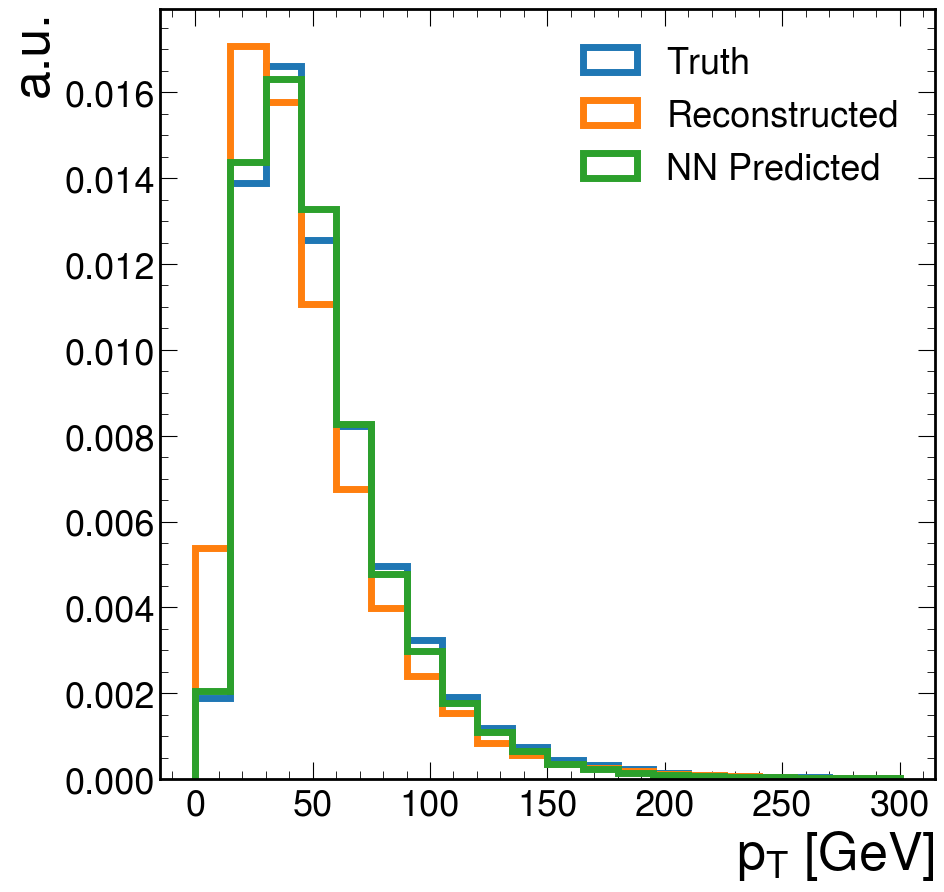

0.3
2043/2043 [==============================] - 1s 529us/step
[1.117419  1.2455108 1.1421196 ... 1.3462164 1.0248616 1.2328961]
[ 67.32449   48.263546 210.72107  ...  60.243187  74.55868   20.959234]


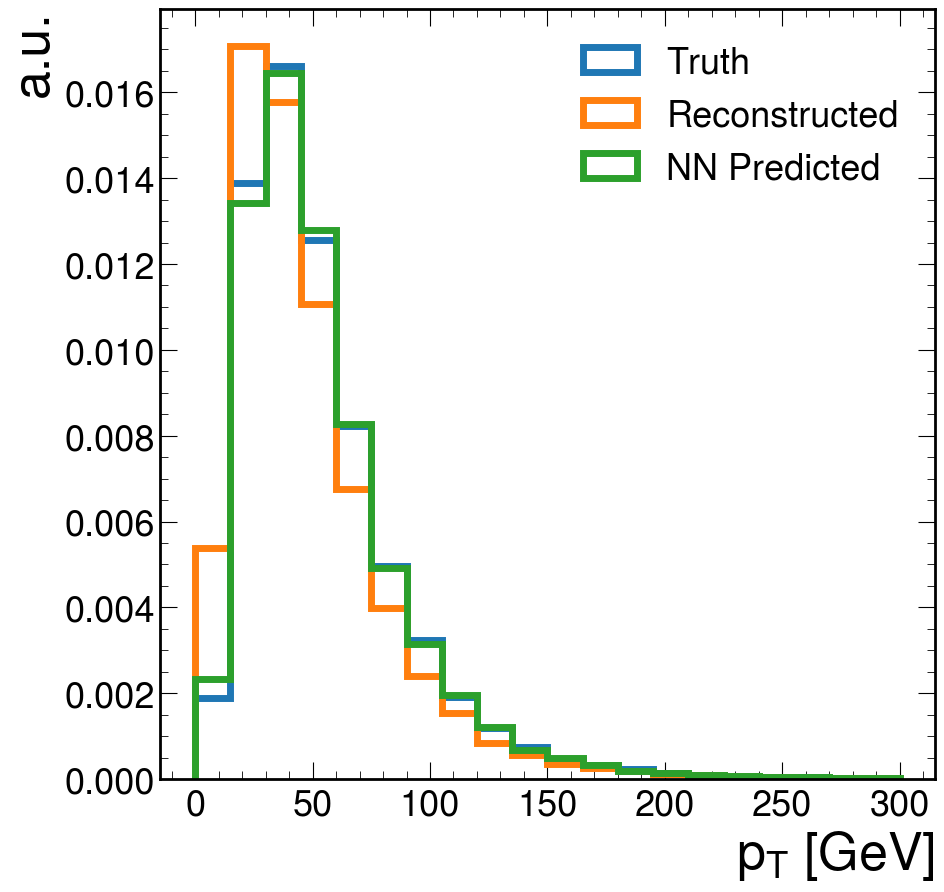

0.6
2043/2043 [==============================] - 1s 524us/step
[1.1810422 1.2856195 1.0989044 ... 1.1597375 0.9722531 1.1880748]
[ 71.15779   49.817757 202.74786  ...  51.89825   70.731415  20.197271]


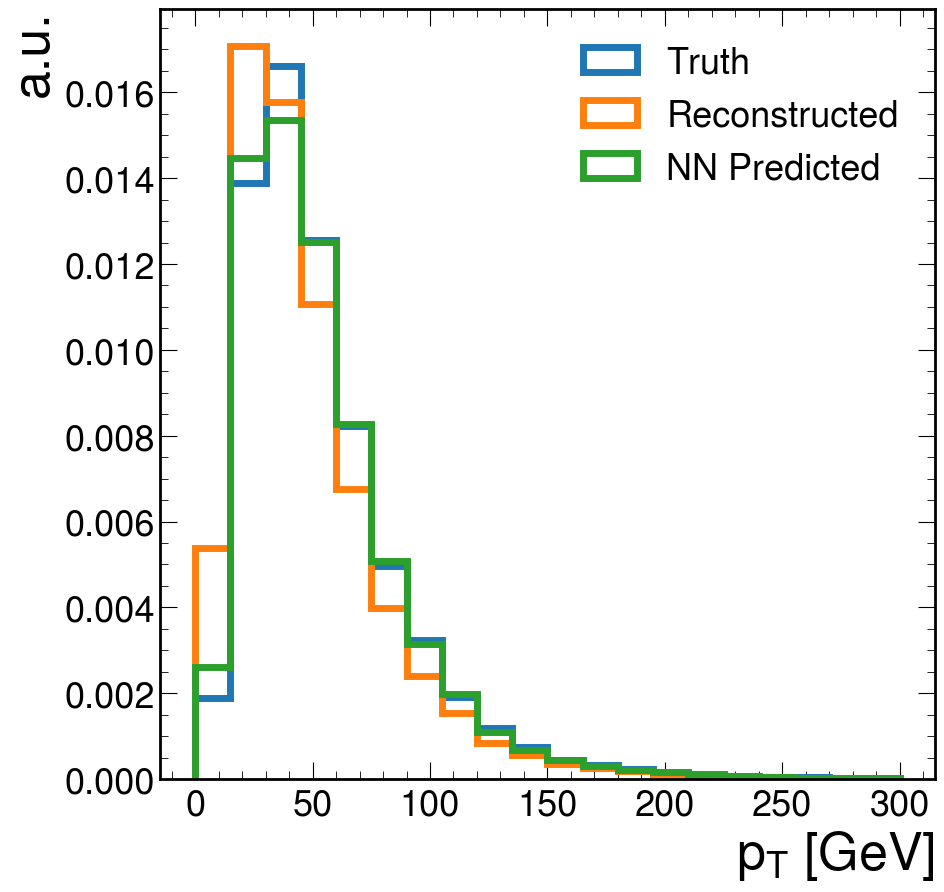

0.65
2043/2043 [==============================] - 1s 523us/step
[1.2523197 1.2936636 1.1857667 ... 1.3193245 1.0148796 1.2091284]
[ 75.45226   50.129467 218.77396  ...  59.039772  73.83249   20.555183]


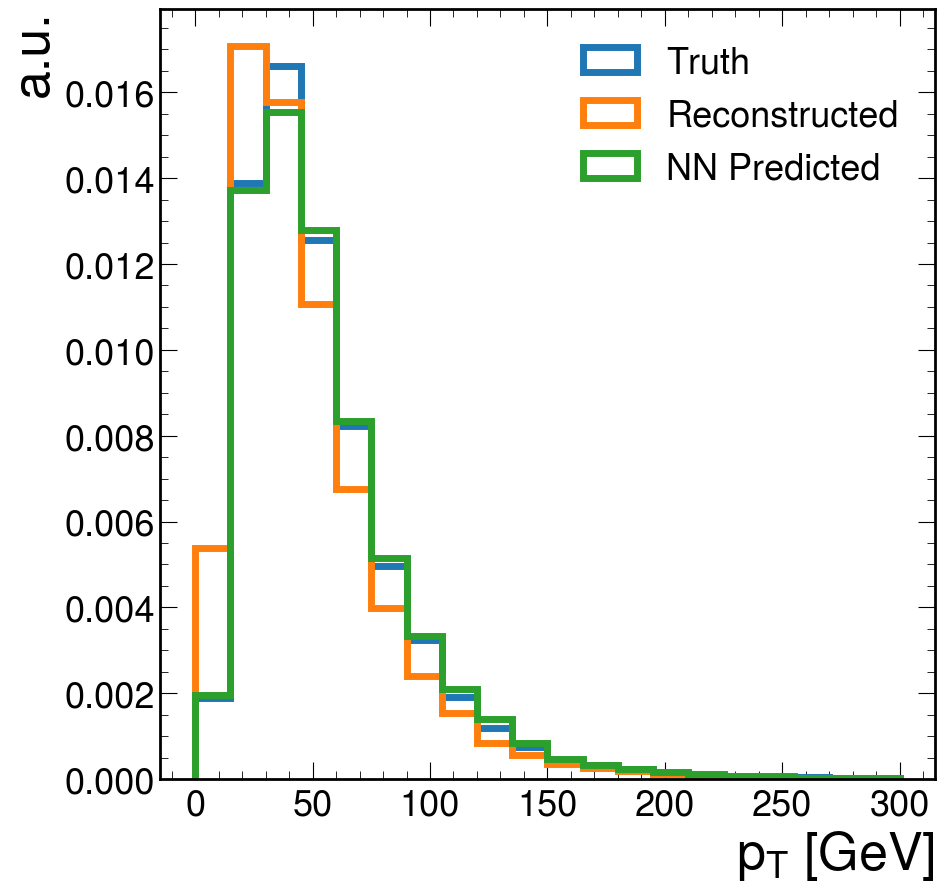

0.7


In [10]:
# load_and_predict_test("../../ntuples/Jan_25_2023", load_model("../models/merged_error_test1.h5"))
for i in range(len(trained_models)):
    load_and_predict_test("../../ntuples/Jan_25_2023", trained_models[i])
    print(gammas[i])

In [11]:
# Looking nice!! 

## Scanning Optimal Gamma using ROC Curve

In [12]:
model_id_name = '../../models/Feb_4_2023_JetMetTalk_v1_pTShape_EMSeed.h5'
model_pt_regress_name = '../models/merged_pt_regress_jet_ID.h5'
model_id = load_model(model_id_name)
#MinBias_nn_score_model = model_id.predict(MinBias_inputs)

model_regress = load_model(model_pt_regress_name)
#MinBias_nn_selected_pt_ratio = model_regress.predict(MinBias_inputs).flatten()

In [19]:
def prep_rate_data(NormalModelID, 
                   ModelNameID,
             ModelNameRegress,
             truth_sig_pt_cut=50,
             minbias_pt_cut_value=50,
             minbias_path = "../../ntuples/Jan_25_2023/test_bkg_v12_emseed.root",
             sig_path = "../../ntuples/Jan_25_2023/test_sig_v12_emseed.root",
             TreeName='ntuplePupSingle',
             test_index=400000):
    
    
    modelID = load_model(NormalModelID)
    
    #Load the data
    MinBias = uproot4.open(minbias_path)
    sig = uproot4.open(sig_path)
    
    #Signal data prep
    truth_pt_sig = sig['ntuplePupSingle']['tree']['genpt1'].array()[test_index:]
    truth_deltaR_sig = sig['ntuplePupSingle']['tree']['gendr1'].array()[test_index:]
    truth_eta_sig = sig['ntuplePupSingle']['tree']['geneta1'].array()[test_index:]

    selection_sig = (truth_pt_sig > truth_sig_pt_cut) & (abs(truth_deltaR_sig) < 0.4) &(abs(truth_eta_sig) < 2.4)

    sig_id = np.asarray(sig['ntuplePupSingle']['tree']['event'].array()[test_index:][selection_sig])
    sig_pt = np.asarray(sig['ntuplePupSingle']['tree']['pt'].array()[test_index:][selection_sig])
    sig_input = np.asarray(sig['ntuplePupSingle']['tree']['m_inputs'].array()[test_index:][selection_sig])      
    
    #Pick out unique events
    minbias_id, minbias_index = np.unique(np.asarray(MinBias[TreeName]['tree']['event'].array()[test_index:]), return_index=True)
    sig_id_temp, sig_index_temp = np.unique(sig_id, return_index=True)
    
    true_sig_id, _, true_signal_index = np.intersect1d(np.unique(minbias_id), np.unique(sig_id_temp), return_indices=True)
    
    #True signal data preparation (these are events that actually overlaps with MinBias)
    true_sig_pt = sig_pt[sig_index_temp][true_signal_index]
    true_sig_input = sig_input[sig_index_temp][true_signal_index]
    true_sig_score = modelID.predict(true_sig_input).flatten()
    
    minbias_pt = MinBias['ntuplePupSingle']['tree']['pt'].array()[test_index:][minbias_index]
    minbias_input = np.asarray(MinBias['ntuplePupSingle']['tree']['m_inputs'].array()[test_index:][minbias_index])
    minbias_input[abs(minbias_input) > 1e+9] = 0.

    minbias_score = modelID.predict(minbias_input).flatten()
    
    #
    sig_pt_cut = true_sig_pt > minbias_pt_cut_value
    minbias_pt_cut = minbias_pt > minbias_pt_cut_value
    
    true_sig_score_pt = true_sig_score[sig_pt_cut]
    minbias_score_pt = minbias_score[minbias_pt_cut]
    
    #Now apply correction
    #model_regress = load_model(ModelNameRegress)
    
    #minbias_pt_corrected_ratio = model_regress.predict(minbias_input).flatten()
    #minbias_pt_corrected = np.multiply(minbias_pt, minbias_pt_corrected_ratio)

    #true_sig_pt_corrected_ratio = model_regress.predict(true_sig_input).flatten()
    #true_sig_pt_corrected = np.multiply(true_sig_pt, true_sig_pt_corrected_ratio)
    
    #sig_pt_cut_corrected = true_sig_pt_corrected > minbias_pt_cut_value
    #minbias_pt_cut_corrected = minbias_pt_corrected > minbias_pt_cut_value
    
    #true_sig_score_pt_corrected = true_sig_score[sig_pt_cut_corrected]
    #minbias_score_pt_corrected = minbias_score[minbias_pt_cut_corrected]
    
    n_event = minbias_index.shape[0]
    n_sig_event = true_sig_id.shape[0]
    
    ##LOOP to calculate the ROC curves
    tau_score_edges = [round(i,2) for i in np.arange(0, 0.8, 0.01).tolist()]+\
                  [round(i,4) for i in np.arange(0.9, 1, 0.0001)] + [1]

    sig_list = []
    bkg_list = []

    for tau_score_cut in tau_score_edges:
    
        bkg_pass = sum(minbias_score_pt>tau_score_cut)
        sig_pass = sum(true_sig_score_pt>tau_score_cut)
        
        sig_list.append(sig_pass/n_sig_event)
        bkg_list.append(bkg_pass/n_event)

    
    bkg_list_scaled = [i*(32e+3) for i in bkg_list]
    
    
    plt.plot(sig_list, bkg_list_scaled, label=r'Tau NN ID (No $p_T$ Correction)',linewidth=3)
    
    
    
    
    
    
    #Load the data
    MinBias = uproot4.open(minbias_path)
    sig = uproot4.open(sig_path)
    
    #Signal data prep
    truth_pt_sig = sig['ntuplePupSingle']['tree']['genpt1'].array()[test_index:]
    truth_deltaR_sig = sig['ntuplePupSingle']['tree']['gendr1'].array()[test_index:]
    truth_eta_sig = sig['ntuplePupSingle']['tree']['geneta1'].array()[test_index:]

    selection_sig = (truth_pt_sig > truth_sig_pt_cut) & (abs(truth_deltaR_sig) < 0.4) &(abs(truth_eta_sig) < 2.4)

    sig_id = np.asarray(sig['ntuplePupSingle']['tree']['event'].array()[test_index:][selection_sig])
    sig_pt = np.asarray(sig['ntuplePupSingle']['tree']['pt'].array()[test_index:][selection_sig])
    sig_input = np.asarray(sig['ntuplePupSingle']['tree']['m_inputs'].array()[test_index:][selection_sig])      
    
    #Pick out unique events
    minbias_id, minbias_index = np.unique(np.asarray(MinBias[TreeName]['tree']['event'].array()[test_index:]), return_index=True)
    sig_id_temp, sig_index_temp = np.unique(sig_id, return_index=True)
    
    true_sig_id, _, true_signal_index = np.intersect1d(np.unique(minbias_id), np.unique(sig_id_temp), return_indices=True)
    
    #True signal data preparation (these are events that actually overlaps with MinBias)
    true_sig_pt = sig_pt[sig_index_temp][true_signal_index]
    true_sig_input = sig_input[sig_index_temp][true_signal_index]
    for i in range(0):
        if i == 0:
            modelID = load_model("../models/merged_11_gamma33.h5") # merged
            model_regress = load_model("../models/merged_11_gamma33.h5")
        elif i == 1:
            modelID = trained_models[3] # merged testing
            model_regress = trained_models[3]
        #modelID = ModelNameID[i]
        true_sig_score = modelID.predict(true_sig_input)[0].flatten()

        minbias_pt = MinBias['ntuplePupSingle']['tree']['pt'].array()[test_index:][minbias_index]
        minbias_input = np.asarray(MinBias['ntuplePupSingle']['tree']['m_inputs'].array()[test_index:][minbias_index])
        minbias_input[abs(minbias_input) > 1e+9] = 0.

        minbias_score = modelID.predict(minbias_input)[0].flatten()

        #
        sig_pt_cut = true_sig_pt > minbias_pt_cut_value
        minbias_pt_cut = minbias_pt > minbias_pt_cut_value

        true_sig_score_pt = true_sig_score[sig_pt_cut]
        minbias_score_pt = minbias_score[minbias_pt_cut]

        #Now apply correction
    #     for i in range(len(ModelNameRegress)):
        #model_regress = load_model(ModelNameRegress)

        minbias_pt_corrected_ratio = model_regress.predict(minbias_input)[1].flatten()
        minbias_pt_corrected = np.multiply(minbias_pt, minbias_pt_corrected_ratio)

        true_sig_pt_corrected_ratio = model_regress.predict(true_sig_input)[1].flatten()
        true_sig_pt_corrected = np.multiply(true_sig_pt, true_sig_pt_corrected_ratio)

        sig_pt_cut_corrected = true_sig_pt_corrected > minbias_pt_cut_value
        minbias_pt_cut_corrected = minbias_pt_corrected > minbias_pt_cut_value

        true_sig_score_pt_corrected = true_sig_score[sig_pt_cut_corrected]
        minbias_score_pt_corrected = minbias_score[minbias_pt_cut_corrected]

        n_event = minbias_index.shape[0]
        n_sig_event = true_sig_id.shape[0]

        ##LOOP to calculate the ROC curves
        tau_score_edges = [round(i,2) for i in np.arange(0, 0.8, 0.01).tolist()]+\
                      [round(i,4) for i in np.arange(0.9, 1, 0.0001)] + [1]

        sig_list_corrected = []
        bkg_list_corrected = []

        for tau_score_cut in tau_score_edges:
            bkg_pass = sum(minbias_score_pt_corrected>tau_score_cut)
            sig_pass = sum(true_sig_score_pt_corrected>tau_score_cut)

            sig_list_corrected.append(sig_pass/n_sig_event)
            bkg_list_corrected.append(bkg_pass/n_event)

        bkg_list_scaled_corrected = [i*(32e+3) for i in bkg_list_corrected]

        plt.plot(sig_list_corrected, bkg_list_scaled_corrected, label=r'Merged, $\gamma=0.3$',linewidth=3)
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    #Load the data
    MinBias = uproot4.open(minbias_path)
    sig = uproot4.open(sig_path)
    
    #Signal data prep
    truth_pt_sig = sig['ntuplePupSingle']['tree']['genpt1'].array()[test_index:]
    truth_deltaR_sig = sig['ntuplePupSingle']['tree']['gendr1'].array()[test_index:]
    truth_eta_sig = sig['ntuplePupSingle']['tree']['geneta1'].array()[test_index:]

    selection_sig = (truth_pt_sig > truth_sig_pt_cut) & (abs(truth_deltaR_sig) < 0.4) &(abs(truth_eta_sig) < 2.4)

    sig_id = np.asarray(sig['ntuplePupSingle']['tree']['event'].array()[test_index:][selection_sig])
    sig_pt = np.asarray(sig['ntuplePupSingle']['tree']['pt'].array()[test_index:][selection_sig])
    sig_input = np.asarray(sig['ntuplePupSingle']['tree']['m_inputs'].array()[test_index:][selection_sig])      
    
    #Pick out unique events
    minbias_id, minbias_index = np.unique(np.asarray(MinBias[TreeName]['tree']['event'].array()[test_index:]), return_index=True)
    sig_id_temp, sig_index_temp = np.unique(sig_id, return_index=True)
    
    true_sig_id, _, true_signal_index = np.intersect1d(np.unique(minbias_id), np.unique(sig_id_temp), return_indices=True)
    
    #True signal data preparation (these are events that actually overlaps with MinBias)
    true_sig_pt = sig_pt[sig_index_temp][true_signal_index]
    true_sig_input = sig_input[sig_index_temp][true_signal_index]
    for i in range(len(ModelNameID)):
        modelID = ModelNameID[i]
        true_sig_score = modelID.predict(true_sig_input)[0].flatten()

        minbias_pt = MinBias['ntuplePupSingle']['tree']['pt'].array()[test_index:][minbias_index]
        minbias_input = np.asarray(MinBias['ntuplePupSingle']['tree']['m_inputs'].array()[test_index:][minbias_index])
        minbias_input[abs(minbias_input) > 1e+9] = 0.

        minbias_score = modelID.predict(minbias_input)[0].flatten()

        #
        sig_pt_cut = true_sig_pt > minbias_pt_cut_value
        minbias_pt_cut = minbias_pt > minbias_pt_cut_value

        true_sig_score_pt = true_sig_score[sig_pt_cut]
        minbias_score_pt = minbias_score[minbias_pt_cut]

        #Now apply correction
    #     for i in range(len(ModelNameRegress)):
        #model_regress = load_model(ModelNameRegress)
        model_regress = ModelNameRegress[i]

        minbias_pt_corrected_ratio = model_regress.predict(minbias_input)[1].flatten()
        minbias_pt_corrected = np.multiply(minbias_pt, minbias_pt_corrected_ratio)

        true_sig_pt_corrected_ratio = model_regress.predict(true_sig_input)[1].flatten()
        true_sig_pt_corrected = np.multiply(true_sig_pt, true_sig_pt_corrected_ratio)

        sig_pt_cut_corrected = true_sig_pt_corrected > minbias_pt_cut_value
        minbias_pt_cut_corrected = minbias_pt_corrected > minbias_pt_cut_value

        true_sig_score_pt_corrected = true_sig_score[sig_pt_cut_corrected]
        minbias_score_pt_corrected = minbias_score[minbias_pt_cut_corrected]

        n_event = minbias_index.shape[0]
        n_sig_event = true_sig_id.shape[0]

        ##LOOP to calculate the ROC curves
        tau_score_edges = [round(i,2) for i in np.arange(0, 0.8, 0.01).tolist()]+\
                      [round(i,4) for i in np.arange(0.9, 1, 0.0001)] + [1]

        sig_list_corrected = []
        bkg_list_corrected = []

        for tau_score_cut in tau_score_edges:
            bkg_pass = sum(minbias_score_pt_corrected>tau_score_cut)
            sig_pass = sum(true_sig_score_pt_corrected>tau_score_cut)

            sig_list_corrected.append(sig_pass/n_sig_event)
            bkg_list_corrected.append(bkg_pass/n_event)

        bkg_list_scaled_corrected = [i*(32e+3) for i in bkg_list_corrected]

        plt.plot(sig_list_corrected, bkg_list_scaled_corrected, label=r'Tau NN ID, $\gamma=$' + str(gammas[i]),linewidth=2)
        hep.cms.text("Phase 2 Simulation")
        hep.cms.lumitext("PU 200 (14 TeV)")

        plt.ylabel(r'$Single \tau_h$ Trigger Rate [kHz]')
        plt.xlabel(r'$\tau_h$ [$p_T^{gen} > % d$ GeV]' %int(truth_sig_pt_cut))

        plt.yscale('log')
        plt.legend(loc='lower right',fontsize=18)
        #plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    
    plt.plot([],[], 'none', label=r'(MinBias $p_T^{reco (or~corrected)}$ >  % d GeV)'%int(minbias_pt_cut_value))
    plt.show()

    return n_event, n_sig_event, true_sig_score_pt, minbias_score_pt, true_sig_score_pt_corrected, minbias_score_pt_corrected


115/115 [==============================] - 0s 541us/step


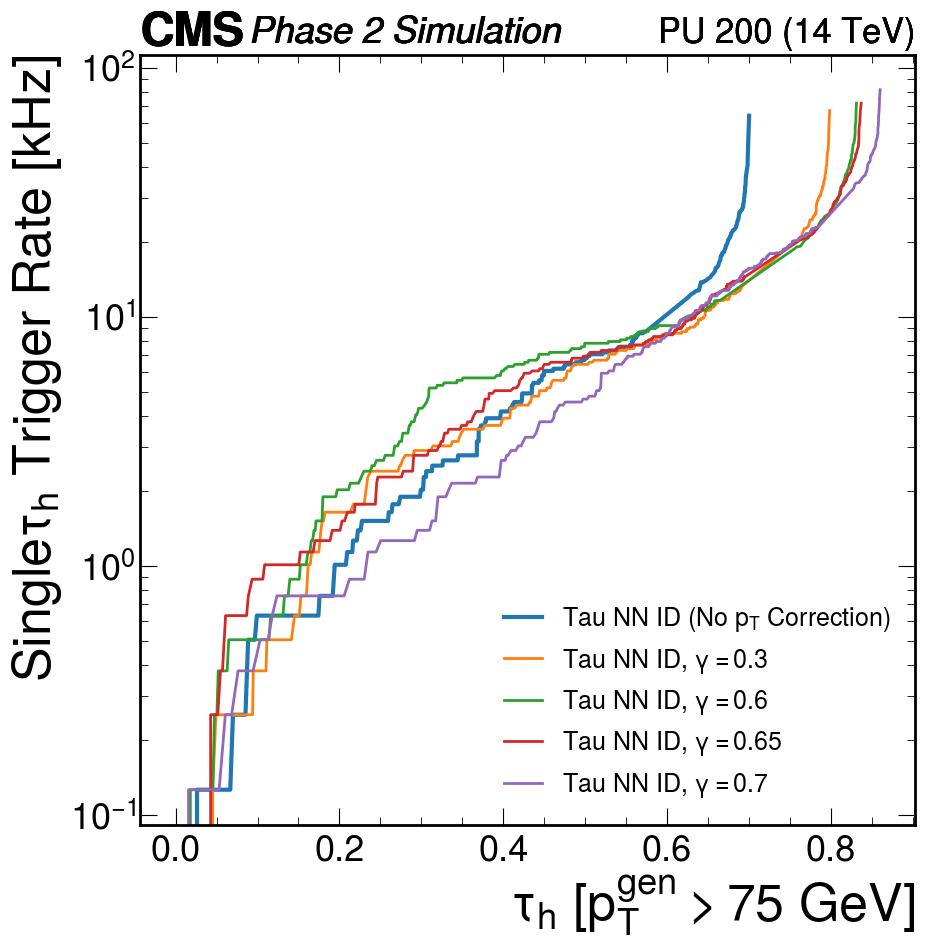

In [20]:
# n_event, n_sig_event, true_sig_score_pt, minbias_score_pt, true_sig_score_pt_corrected, minbias_score_pt_corrected = prep_rate_data(model_id_name,
#                                                                                                                                     trained_models,
#                                                                                                                                     truth_sig_pt_cut=75,
#                                                                                                                                     minbias_pt_cut_value=75)

n_event, n_sig_event, true_sig_score_pt, minbias_score_pt, true_sig_score_pt_corrected, minbias_score_pt_corrected = prep_rate_data(model_id_name,
                                                                                                                                    trained_models,
                                                                                                                                    trained_models,
                                                                                                                                    truth_sig_pt_cut=75,
                                                                                                                                    minbias_pt_cut_value=75)

10337/10337 [==============================] - 7s 647us/step
[[0.99708486]
 [0.94427496]
 [0.984961  ]
 ...
 [0.01065095]
 [0.71297455]
 [0.50917965]]
10337/10337 [==============================] - 7s 653us/step
[[0.99750763]
 [0.97295976]
 [0.9647553 ]
 ...
 [0.01797687]
 [0.54496455]
 [0.4236817 ]]
10337/10337 [==============================] - 6s 612us/step
[[0.99395573]
 [0.9512467 ]
 [0.97158873]
 ...
 [0.02393433]
 [0.34633687]
 [0.51992744]]
10337/10337 [==============================] - 6s 619us/step
[[0.99806726]
 [0.98173463]
 [0.9742275 ]
 ...
 [0.10419326]
 [0.5704226 ]
 [0.49446633]]


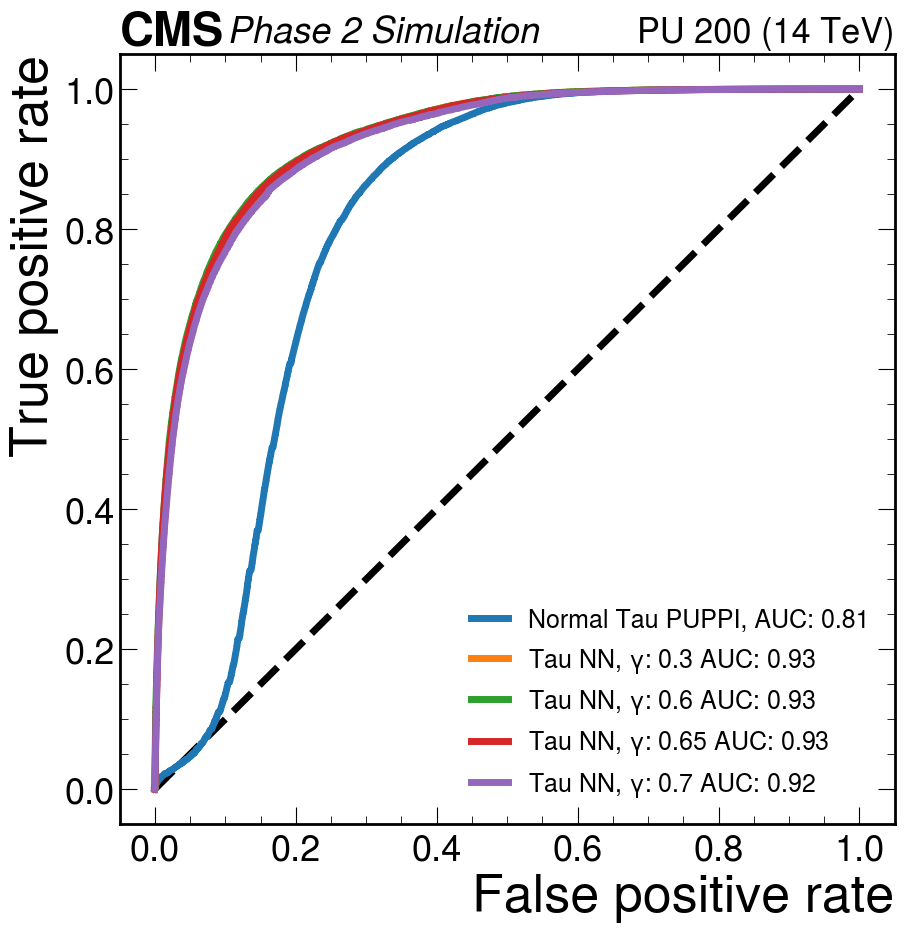

In [21]:
NormalModel = load_model(model_id_name)

#model_id_name = '../../models/Feb_4_2023_JetMetTalk_v1_SigPtTruth20.h5'
# model_pt_regress_name = '../models/merged_pt_regress_jet_ID.h5'
# #model_id = load_model(model_id_name)
# model_train_id = load_model(model_pt_regress_name)


y_pred_normal = NormalModel.predict(X_test)
fpr_normal, tpr_normal, _ = roc_curve(y_test_jetID,y_pred_normal)
#     auc_score_normal = round(auc(fpr_normal, tpr_normal),2)
auc_score_normal = round(auc(fpr_normal, tpr_normal), 2)
#Create plot for ROC
plt.figure(1)

plt.plot([0,1],[0,1],'k--')
plt.plot(fpr_normal, tpr_normal, label = 'Normal Tau PUPPI, AUC: {}'.format(auc_score_normal))
#Establish labels and save image
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')

    
for i in range(len(trained_models)):
    y_pred_mono = trained_models[i].predict(X_test)[0]
    print(y_pred_mono)
    fpr_mono, tpr_mono, _ = roc_curve(y_test_jetID, y_pred_mono)
#     auc_score_mono = round(auc(fpr_mono, tpr_mono),2)
    auc_score_mono = round(auc(fpr_mono, tpr_mono), 2)



   
    plt.plot(fpr_mono, tpr_mono, label = 'Tau NN, $\gamma$: ' + str(gammas[i]) + ' AUC: {}'.format(auc_score_mono))

hep.cms.text("Phase 2 Simulation")
hep.cms.lumitext("PU 200 (14 TeV)")  
plt.legend(loc = 'lower right', fontsize = 18)
#plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

### Combined ROC Curve

In [16]:
model_id_name = '../../models/Feb_4_2023_JetMetTalk_v1_pTShape_EMSeed.h5'
model_pt_regress_name = '../models/merged_pt_regress_jet_ID.h5'
model_id = load_model(model_id_name)
#MinBias_nn_score_model = model_id.predict(MinBias_inputs)

model_regress = load_model(model_pt_regress_name)
#MinBias_nn_selected_pt_ratio = model_regress.predict(MinBias_inputs).flatten()

In [17]:
def prep_rate_data(NormalModelID, 
                   ModelNameID,
             ModelNameRegress,
             truth_sig_pt_cut=50,
             minbias_pt_cut_value=50,
             minbias_path = "../../ntuples/Jan_25_2023/test_bkg_v12_emseed.root",
             sig_path = "../../ntuples/Jan_25_2023/test_sig_v12_emseed.root",
             TreeName='ntuplePupSingle',
             test_index=400000):
    
    
    modelID = load_model(model_id_name)
    
    #Load the data
    MinBias = uproot4.open(minbias_path)
    sig = uproot4.open(sig_path)
    
    #Signal data prep
    truth_pt_sig = sig['ntuplePupSingle']['tree']['genpt1'].array()[test_index:]
    truth_deltaR_sig = sig['ntuplePupSingle']['tree']['gendr1'].array()[test_index:]
    truth_eta_sig = sig['ntuplePupSingle']['tree']['geneta1'].array()[test_index:]

    selection_sig = (truth_pt_sig > truth_sig_pt_cut) & (abs(truth_deltaR_sig) < 0.4) &(abs(truth_eta_sig) < 2.4)

    sig_id = np.asarray(sig['ntuplePupSingle']['tree']['event'].array()[test_index:][selection_sig])
    sig_pt = np.asarray(sig['ntuplePupSingle']['tree']['pt'].array()[test_index:][selection_sig])
    sig_input = np.asarray(sig['ntuplePupSingle']['tree']['m_inputs'].array()[test_index:][selection_sig])      
    
    #Pick out unique events
    minbias_id, minbias_index = np.unique(np.asarray(MinBias[TreeName]['tree']['event'].array()[test_index:]), return_index=True)
    sig_id_temp, sig_index_temp = np.unique(sig_id, return_index=True)
    
    true_sig_id, _, true_signal_index = np.intersect1d(np.unique(minbias_id), np.unique(sig_id_temp), return_indices=True)
    
    #True signal data preparation (these are events that actually overlaps with MinBias)
    true_sig_pt = sig_pt[sig_index_temp][true_signal_index]
    true_sig_input = sig_input[sig_index_temp][true_signal_index]
    true_sig_score = modelID.predict(true_sig_input).flatten()
    
    minbias_pt = MinBias['ntuplePupSingle']['tree']['pt'].array()[test_index:][minbias_index]
    minbias_input = np.asarray(MinBias['ntuplePupSingle']['tree']['m_inputs'].array()[test_index:][minbias_index])
    minbias_input[abs(minbias_input) > 1e+9] = 0.

    minbias_score = modelID.predict(minbias_input).flatten()
    
    #
    sig_pt_cut = true_sig_pt > minbias_pt_cut_value
    minbias_pt_cut = minbias_pt > minbias_pt_cut_value
    
    true_sig_score_pt = true_sig_score[sig_pt_cut]
    minbias_score_pt = minbias_score[minbias_pt_cut]
    
    #Now apply correction
    model_regress = load_model("../models/pt_regress_v1_bestest.h5")
    
    minbias_pt_corrected_ratio = model_regress.predict(minbias_input).flatten()
    minbias_pt_corrected = np.multiply(minbias_pt, minbias_pt_corrected_ratio)

    true_sig_pt_corrected_ratio = model_regress.predict(true_sig_input).flatten()
    true_sig_pt_corrected = np.multiply(true_sig_pt, true_sig_pt_corrected_ratio)
    
    sig_pt_cut_corrected = true_sig_pt_corrected > minbias_pt_cut_value
    minbias_pt_cut_corrected = minbias_pt_corrected > minbias_pt_cut_value
    
    true_sig_score_pt_corrected = true_sig_score[sig_pt_cut_corrected]
    minbias_score_pt_corrected = minbias_score[minbias_pt_cut_corrected]
    
    n_event = minbias_index.shape[0]
    n_sig_event = true_sig_id.shape[0]
    
    ##LOOP to calculate the ROC curves
    tau_score_edges = [round(i,2) for i in np.arange(0, 0.8, 0.01).tolist()]+\
                  [round(i,4) for i in np.arange(0.9, 1, 0.0001)] + [1]

    sig_list = []
    bkg_list = []

    for tau_score_cut in tau_score_edges:
    
        bkg_pass = sum(minbias_score_pt>tau_score_cut)
        sig_pass = sum(true_sig_score_pt>tau_score_cut)
        
        sig_list.append(sig_pass/n_sig_event)
        bkg_list.append(bkg_pass/n_event)

    
    bkg_list_scaled = [i*(32e+3) for i in bkg_list]
    
    sig_list_corrected = []
    bkg_list_corrected = []

    for tau_score_cut in tau_score_edges:
        bkg_pass = sum(minbias_score_pt_corrected>tau_score_cut)
        sig_pass = sum(true_sig_score_pt_corrected>tau_score_cut)

        sig_list_corrected.append(sig_pass/n_sig_event)
        bkg_list_corrected.append(bkg_pass/n_event)

    bkg_list_scaled_corrected = [i*(32e+3) for i in bkg_list_corrected]
    
    
    plt.plot([],[], 'none', label=r'(MinBias $p_T^{reco (or~corrected)}$ >  % d GeV)'%int(minbias_pt_cut_value))
    plt.plot(sig_list, bkg_list_scaled, label=r'No $p_T$ Correction',linewidth=3)
    plt.plot(sig_list_corrected, bkg_list_scaled_corrected, label=r'ID + $p_T$ correction separate',linewidth=3)
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    #Load the data
    MinBias = uproot4.open(minbias_path)
    sig = uproot4.open(sig_path)
    
    #Signal data prep
    truth_pt_sig = sig['ntuplePupSingle']['tree']['genpt1'].array()[test_index:]
    truth_deltaR_sig = sig['ntuplePupSingle']['tree']['gendr1'].array()[test_index:]
    truth_eta_sig = sig['ntuplePupSingle']['tree']['geneta1'].array()[test_index:]

    selection_sig = (truth_pt_sig > truth_sig_pt_cut) & (abs(truth_deltaR_sig) < 0.4) &(abs(truth_eta_sig) < 2.4)

    sig_id = np.asarray(sig['ntuplePupSingle']['tree']['event'].array()[test_index:][selection_sig])
    sig_pt = np.asarray(sig['ntuplePupSingle']['tree']['pt'].array()[test_index:][selection_sig])
    sig_input = np.asarray(sig['ntuplePupSingle']['tree']['m_inputs'].array()[test_index:][selection_sig])      
    
    #Pick out unique events
    minbias_id, minbias_index = np.unique(np.asarray(MinBias[TreeName]['tree']['event'].array()[test_index:]), return_index=True)
    sig_id_temp, sig_index_temp = np.unique(sig_id, return_index=True)
    
    true_sig_id, _, true_signal_index = np.intersect1d(np.unique(minbias_id), np.unique(sig_id_temp), return_indices=True)
    
    #True signal data preparation (these are events that actually overlaps with MinBias)
    true_sig_pt = sig_pt[sig_index_temp][true_signal_index]
    true_sig_input = sig_input[sig_index_temp][true_signal_index]
    for i in range(1):
        if i == 1:
            modelID = load_model("../models/merged_11_gamma33.h5") # merged
            model_regress = load_model("../models/merged_11_gamma33.h5")
        elif i == 0:
            modelID = load_model("../models/new_merged.h5")
            model_regress = load_model("../models/new_merged.h5")
        #modelID = ModelNameID[i]
        true_sig_score = modelID.predict(true_sig_input)[0].flatten()

        minbias_pt = MinBias['ntuplePupSingle']['tree']['pt'].array()[test_index:][minbias_index]
        minbias_input = np.asarray(MinBias['ntuplePupSingle']['tree']['m_inputs'].array()[test_index:][minbias_index])
        minbias_input[abs(minbias_input) > 1e+9] = 0.

        minbias_score = modelID.predict(minbias_input)[0].flatten()

        #
        sig_pt_cut = true_sig_pt > minbias_pt_cut_value
        minbias_pt_cut = minbias_pt > minbias_pt_cut_value

        true_sig_score_pt = true_sig_score[sig_pt_cut]
        minbias_score_pt = minbias_score[minbias_pt_cut]

        #Now apply correction
    #     for i in range(len(ModelNameRegress)):
        #model_regress = load_model(ModelNameRegress)

        minbias_pt_corrected_ratio = model_regress.predict(minbias_input)[1].flatten()
        minbias_pt_corrected = np.multiply(minbias_pt, minbias_pt_corrected_ratio)

        true_sig_pt_corrected_ratio = model_regress.predict(true_sig_input)[1].flatten()
        true_sig_pt_corrected = np.multiply(true_sig_pt, true_sig_pt_corrected_ratio)

        sig_pt_cut_corrected = true_sig_pt_corrected > minbias_pt_cut_value
        minbias_pt_cut_corrected = minbias_pt_corrected > minbias_pt_cut_value

        true_sig_score_pt_corrected = true_sig_score[sig_pt_cut_corrected]
        minbias_score_pt_corrected = minbias_score[minbias_pt_cut_corrected]

        n_event = minbias_index.shape[0]
        n_sig_event = true_sig_id.shape[0]

        ##LOOP to calculate the ROC curves
        tau_score_edges = [round(i,2) for i in np.arange(0, 0.8, 0.01).tolist()]+\
                      [round(i,4) for i in np.arange(0.9, 1, 0.0001)] + [1]

        sig_list_corrected = []
        bkg_list_corrected = []

        for tau_score_cut in tau_score_edges:
            bkg_pass = sum(minbias_score_pt_corrected>tau_score_cut)
            sig_pass = sum(true_sig_score_pt_corrected>tau_score_cut)

            sig_list_corrected.append(sig_pass/n_sig_event)
            bkg_list_corrected.append(bkg_pass/n_event)

        bkg_list_scaled_corrected = [i*(32e+3) for i in bkg_list_corrected]

        plt.plot(sig_list_corrected, bkg_list_scaled_corrected, label=r'Merged Full-bits, $\gamma=0.7$',linewidth=3)
        hep.cms.text("Phase 2 Simulation")
        hep.cms.lumitext("PU 200 (14 TeV)")

        plt.ylabel(r'$Single \tau_h$ Trigger Rate [kHz]')
        plt.xlabel(r'$\tau_h$ [$p_T^{gen} > % d$ GeV]' %int(truth_sig_pt_cut))

        plt.yscale('log')
        #plt.legend(loc='best',fontsize=20)
        plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    
    plt.plot([],[], 'none', label=r'(MinBias $p_T^{reco (or~corrected)}$ >  % d GeV)'%int(minbias_pt_cut_value))
    plt.show()
    
    total = 0
    for i in range(len(sig_list_corrected)):
        total += bkg_list_scaled_corrected[i] / bkg_list_scaled[i]
    print(total / len(sig_list_corrected))
    return n_event, n_sig_event, true_sig_score_pt, minbias_score_pt, true_sig_score_pt_corrected, minbias_score_pt_corrected


115/115 [==============================] - 0s 565us/step


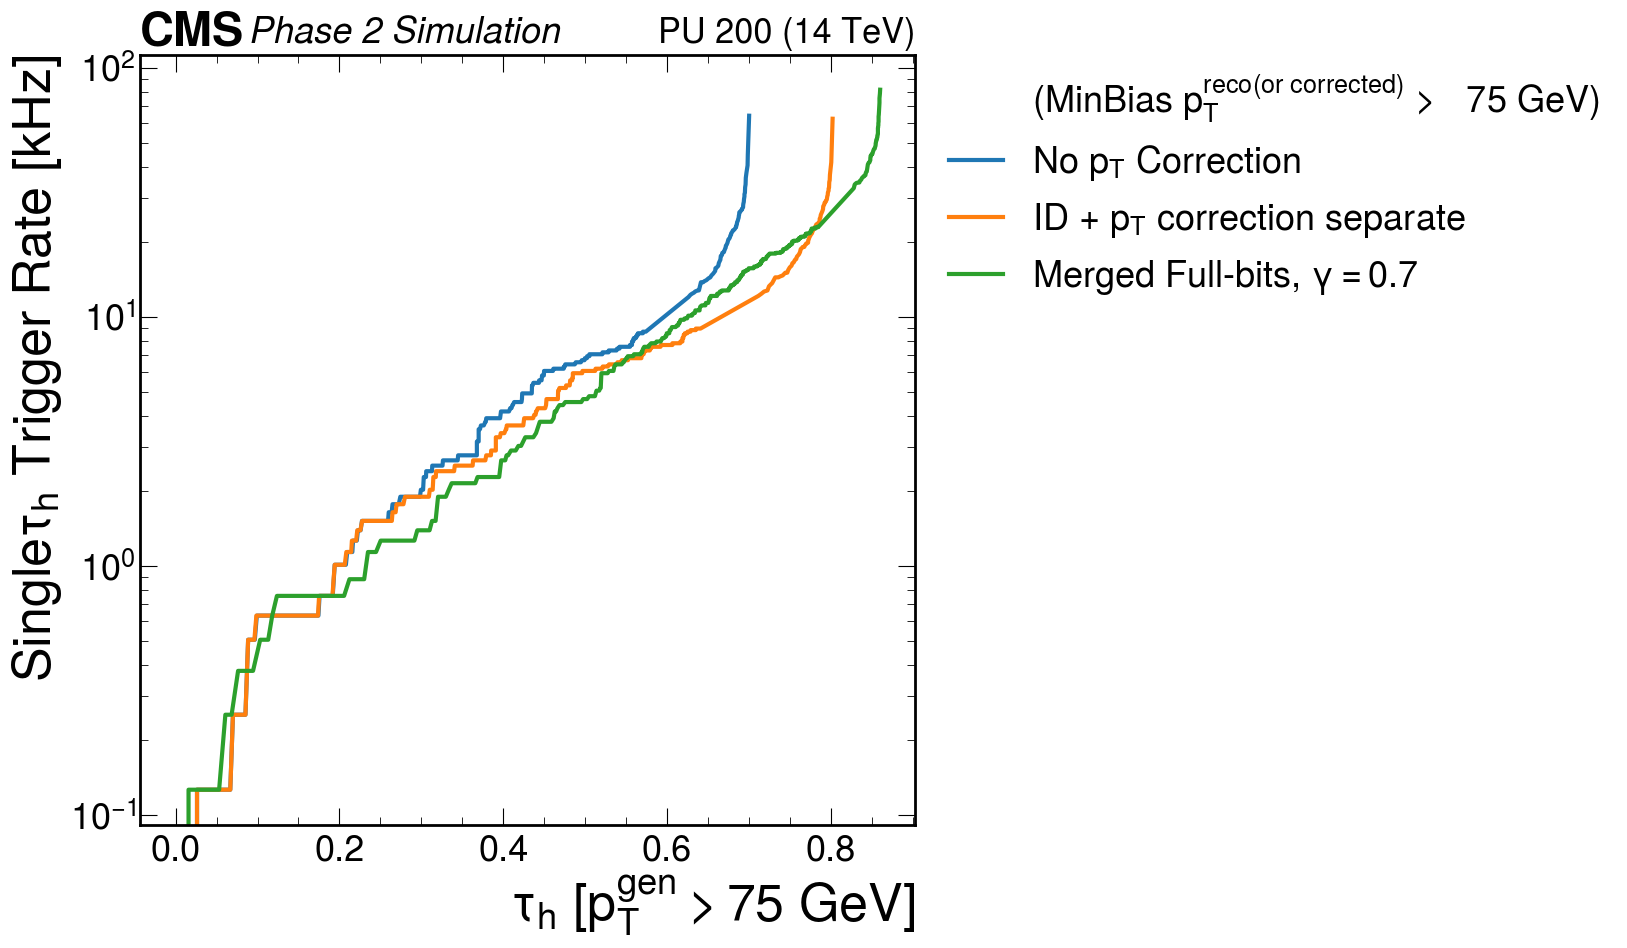

nan


/tmp/ipykernel_2788919/2006444636.py:220: RuntimeWarning: divide by zero encountered in double_scalars
  total += bkg_list_scaled_corrected[i] / bkg_list_scaled[i]
/tmp/ipykernel_2788919/2006444636.py:220: RuntimeWarning: invalid value encountered in double_scalars
  total += bkg_list_scaled_corrected[i] / bkg_list_scaled[i]


In [18]:
# n_event, n_sig_event, true_sig_score_pt, minbias_score_pt, true_sig_score_pt_corrected, minbias_score_pt_corrected = prep_rate_data(model_id_name,
#                                                                                                                                     trained_models,
#                                                                                                                                     truth_sig_pt_cut=75,
#                                                                                                                                     minbias_pt_cut_value=75)

n_event, n_sig_event, true_sig_score_pt, minbias_score_pt, true_sig_score_pt_corrected, minbias_score_pt_corrected = prep_rate_data(model_id_name,
                                                                                                                                    "b",
                                                                                                                                    "b",
                                                                                                                                    truth_sig_pt_cut=75,
                                                                                                                                    minbias_pt_cut_value=75)